In [205]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pysindy as ps 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge, ElasticNet, Lars
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet
from scipy.stats import norm
from datetime import datetime
from scipy.integrate import solve_ivp
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from pysindy.utils.odes import lorenz
from decimal import Decimal, getcontext


#### SPY options

In [49]:
calls=pd.read_csv('data/calls.csv')
puts=pd.read_csv('data/puts.csv')
underlying=pd.read_csv('data/underlying_data.csv')

calls.index=calls[calls.columns[0]]
calls=calls.drop(columns=calls.columns[0])

puts.index=puts[puts.columns[0]]
puts=puts.drop(columns=puts.columns[0])

underlying.index=underlying[underlying.columns[0]]
underlying=underlying.drop(columns=underlying.columns[0])

In [50]:
calls['underlying']=underlying['price']
calls.index=[datetime.strptime(i,"%Y-%m-%d") for i in calls.index]
calls['time_to_exp']=[(datetime(2022,9,30)-i).days/365 for i in calls.index]
# calls=calls[calls['time_to_exp']<0.8]
calls=calls.sort_index()[::-1]


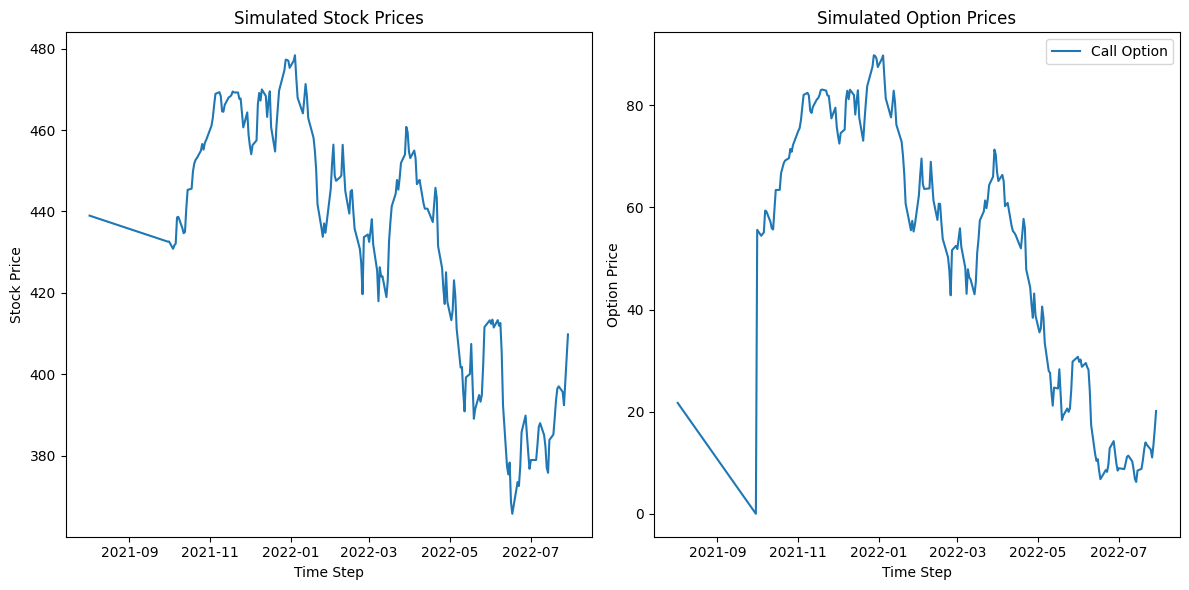

In [51]:
# Plot the simulated stock prices and option prices
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(calls['underlying'])
plt.title('Simulated Stock Prices')
plt.xlabel('Time Step')
plt.ylabel('Stock Price')

plt.subplot(1, 2, 2)
plt.plot(calls['price'], label='Call Option')
# plt.plot(option_prices_put, label='Put Option')
plt.title('Simulated Option Prices')
plt.xlabel('Time Step')
plt.ylabel('Option Price')
plt.legend()

plt.tight_layout()
plt.show()

In [7]:
u = np.real(calls['price'])
t = np.ravel(calls['time_to_exp'])
x = np.ravel(calls['underlying'])
# u_dot =  ps.FiniteDifference(axis=0)._differentiate(x= C,t=dt)
# dt = 1
# dt = ps.FiniteDifference(axis=0)._differentiate(x= t,t=1)


### Synthetic Option

In [206]:


def black_scholes_call(S, X, T, r, sigma):
    d1 = (np.log(S / X) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / X) + (r - 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    call_price = S * norm.cdf(d1) - X * np.exp(-r * T) * norm.cdf(d2)
    return call_price

def numerical_partial_black_scholes(V,r,sigma):
    N = len(V[0])
    M = len(V[:,0])
    V_dot = np.zeros([M,N])

    alpha = 0.5*(sigma**2)
    beta = 0.5*r

    #Calculate option-value
    for m in range(M):
        v_m = []
        for n in range(1,N-1):
                v_m.append((beta*n - alpha*(n**2))*V[m,n-1] + 2*(beta + alpha*(n**2))*V[m,n] - (alpha*(n**2) + beta*n)*V[m,n+1])
        V_dot[m] = [0] + v_m + [0]
    return V_dot

In [239]:


# Constants
r = 0.05
sigma = 0.4
K = 105
T = 1.

timesteps = 1200
spacesteps =  120

# Monte Carlo simulation
x = np.linspace(0, K*3, spacesteps)
t = np.linspace(0, T, timesteps)
X, T = np.meshgrid(x, t)

dt = t[1] - t[0]
dx = x[1] - x[0]

X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T

# Calculate 'tal' using vectorized operations
tal = (np.max(t) - T)

# Calculate the call prices using vectorized operations
call_prices = black_scholes_call(X, K, tal, r, sigma)

# u is the call_prices array
u = call_prices.T

C:\Users\Bruno Trotti\AppData\Local\Temp\ipykernel_9884\3155528736.py:2: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(S / X) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
C:\Users\Bruno Trotti\AppData\Local\Temp\ipykernel_9884\3155528736.py:2: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S / X) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
C:\Users\Bruno Trotti\AppData\Local\Temp\ipykernel_9884\3155528736.py:3: RuntimeWarning: divide by zero encountered in log
  d2 = (np.log(S / X) + (r - 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
C:\Users\Bruno Trotti\AppData\Local\Temp\ipykernel_9884\3155528736.py:3: RuntimeWarning: divide by zero encountered in divide
  d2 = (np.log(S / X) + (r - 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


Error for DURA-MOS¸NEAGU Computation
RSE 0.00845913983538783
RMSE 178.83172536504983
Error for Finite Difference 
RSE 0.0037045538820324937
RMSE 118.34486606350502
Error for Smoothed Finite Difference
RSE 0.038514426928866835
RMSE 381.5866608495711


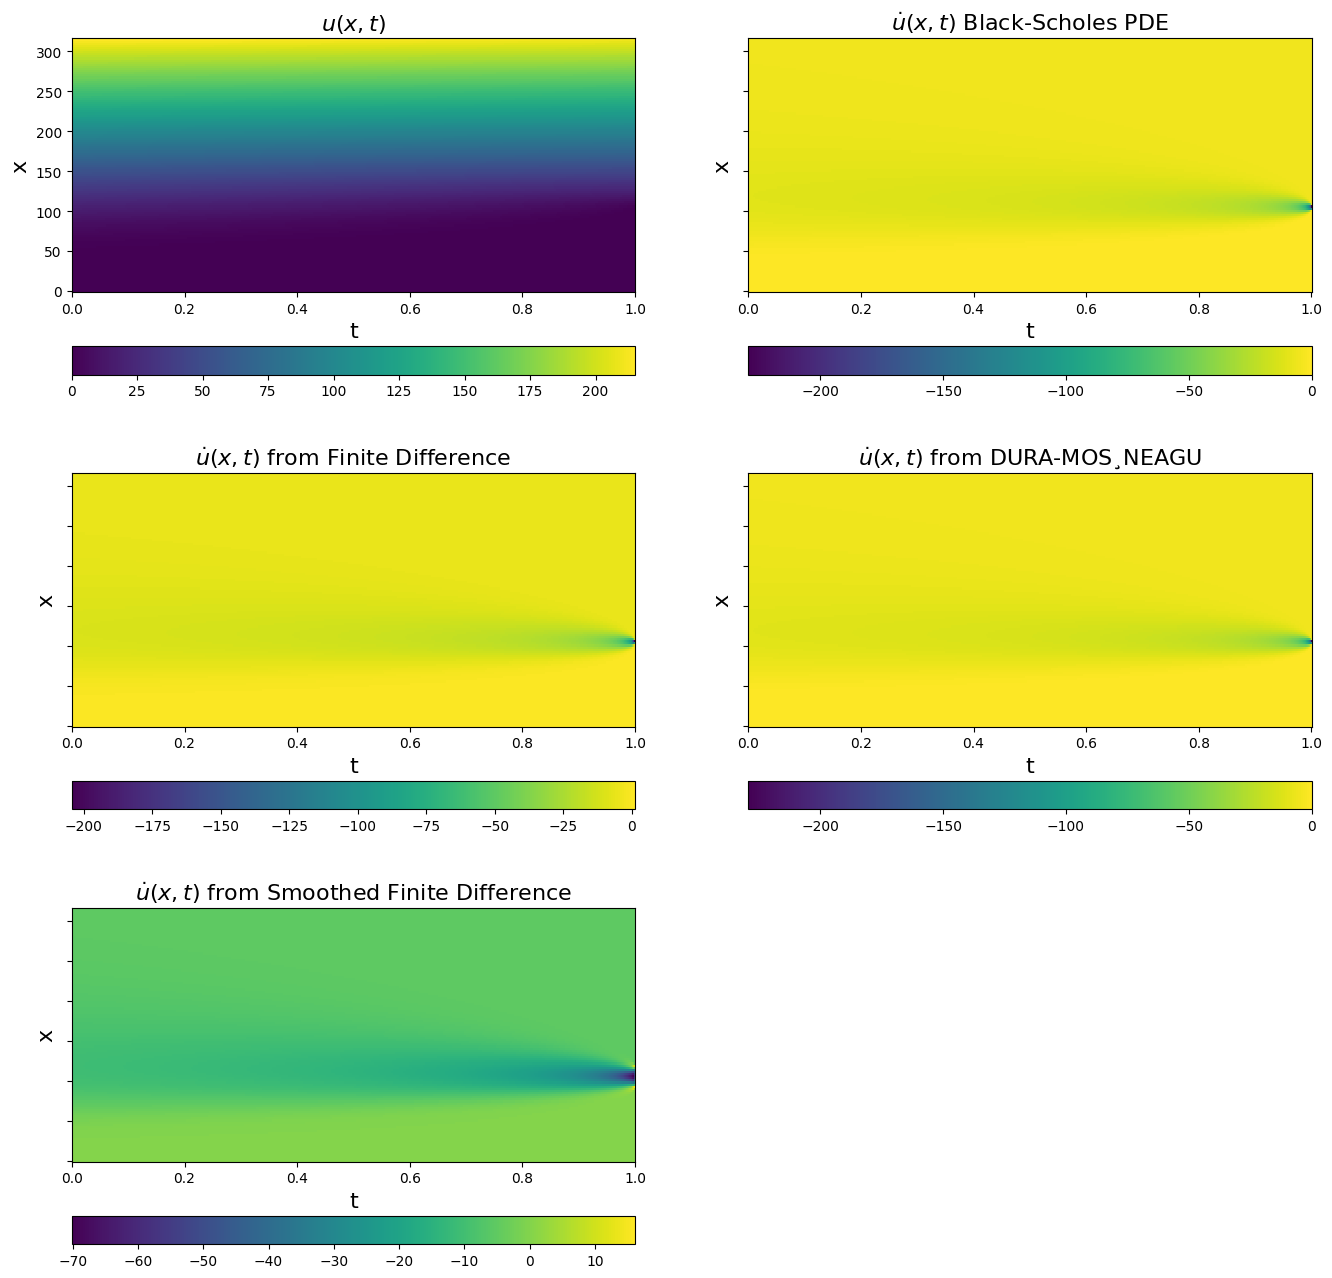

In [245]:
n_arr = np.asarray([np.arange(0,spacesteps,1)]*timesteps).T
u_x = ps.FiniteDifference(axis=0,order = 2)._differentiate(u,t = dx)
u_xx = ps.FiniteDifference(axis=0,d=2,order = 2)._differentiate(u,t = dx)
u_t = ps.FiniteDifference(axis=1,order = 2)._differentiate(u,t = dt)
u_t_ = ps.SmoothedFiniteDifference(axis=1,order = 1)._differentiate(u,t = dt)
v_dot = numerical_partial_black_scholes(u.T,r,sigma).T

adapt_u_xx = u_xx * (dx**2)
adapt_u_x = u_x * (dx)


# Plot u and u_dot
plt.figure(figsize=(16, 16))
plt.subplot(3, 2, 1)
plt.pcolormesh(t, x, u)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
plt.title(r"$u(x, t)$", fontsize=16)
plt.colorbar(orientation="horizontal")

plt.subplot(3, 2, 4)
plt.pcolormesh(t, x, v_dot)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r"$\dot{u}(x, t)$ from DURA-MOS¸NEAGU", fontsize=16)
plt.colorbar(orientation="horizontal")

u_dot = -(1/2)*((sigma**2)*(X.T**2)*u_xx) - (r*(X.T)*u_x) + r*u
plt.subplot(3, 2, 2)
plt.pcolormesh(t, x, u_dot)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r"$\dot{u}(x, t)$ Black-Scholes PDE", fontsize=16)
plt.colorbar(orientation="horizontal")


plt.subplot(3, 2, 3)
plt.pcolormesh(t, x, u_t)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r"$\dot{u}(x, t)$ from Finite Difference", fontsize=16)
plt.colorbar(orientation="horizontal")

plt.subplot(3, 2, 5)
plt.pcolormesh(t, x, u_t_)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r"$\dot{u}(x, t)$ from Smoothed Finite Difference", fontsize=16)
plt.colorbar(orientation="horizontal")


print('Error for DURA-MOS¸NEAGU Computation')
print('RSE',np.sum((u_dot - v_dot)**2)/np.sum((u_dot - u_dot.mean())**2))
print('RMSE',(np.sqrt(np.sum((u_dot - v_dot)**2).mean())))
print('Error for Finite Difference ')
print('RSE',np.sum((u_dot - u_t)**2)/np.sum((u_dot - u_dot.mean())**2))
print('RMSE',(np.sqrt(np.sum((u_dot - u_t)**2).mean())))
print('Error for Smoothed Finite Difference')
print('RSE',np.sum((u_dot - u_t_)**2)/np.sum((u_dot - u_dot.mean())**2))
print('RMSE',(np.sqrt(np.sum((u_dot - u_t_)**2).mean())))

plt.show()

### PySINDy

In [254]:
def print_model(coefs:list,var_names:list):
    eq = 'u_t ='
    for coef,var in zip(coefs, var_names):
        if coef != 0:
            eq += ' + ' + "{:.3f}".format(coef) + ' ' + var
    print(eq)

In [255]:
u = np.reshape(u, (len(x), len(t), 1))
u_dot  = np.reshape(u_dot, (len(x), len(t), 1))
u_t  = np.reshape(u_t, (len(x), len(t), 1))
v_dot  = np.reshape(v_dot, (len(x), len(t), 1))
u_t_ = np.reshape(u_t_, (len(x), len(t), 1))
spatial_grid = np.reshape(X.T, (len(x), len(t), 1))
library_functions = [lambda x: x]
library_function_names = [lambda x: x]

pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    include_interaction = False,
    derivative_order=2,
    spatial_grid=x,
    include_bias=False,
    is_uniform=True,
    periodic=True # uniformly sampled in time
)

u_final = pde_lib.fit_transform(u)
u_final = np.concatenate((u_final,spatial_grid,spatial_grid**2),axis=2)
dic_var = {'x0':'u','x1':'u_x', 'x2':'u_xx','x3':'x','x4':'x^2'}
library_functions = [lambda x: x,lambda x,y: x*y]
library_function_names = [lambda x: dic_var[x],lambda x,y: dic_var[x] + '*' + dic_var[y]]
lib = ps.CustomLibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    include_bias=False
)

In [256]:
print('--------------------------Original Black-scholes-----------------------------')
print('STLSQ Regression')
optimizer = ps.STLSQ(normalize_columns=True)
model = ps.SINDy(feature_library=lib, optimizer=optimizer)
model.fit(u_final,x_dot = u_dot)
# print(model.score(u_test))
model.print()


print('----------------------------Finite Difference--------------------------------')
print('STLSQ Regression')
optimizer = ps.STLSQ(threshold=7e-3, alpha=1e-1)
model = ps.SINDy(feature_library=lib, optimizer=optimizer)
model.fit(u_final,x_dot = u_t)
# print(model.score(u_test))
model.print()
print('Error Model prediction against analytical solution:')
pred = model.predict(u_final)
print('R2',model.score(x = u_final,x_dot = u_dot))
print('RSE',np.sum((pred.flatten() - u_dot.flatten())**2)/np.sum((u_dot.flatten() - u_dot.flatten().mean())**2))
print('RMSE',(np.sqrt(np.sum((pred.flatten() - u_dot.flatten())**2).mean())))

print('*'*50)

print('Ensemble method')
optimizer = ps.STLSQ(threshold=7e-3, alpha=1e-1)
# optimizer = ps.SR3(threshold=0.01,nu = .1 , max_iter=1000, tol=1e-10,thresholder='l0')
# optimizer = ps.SSR(alpha=.1,kappa = .001,)

model = ps.SINDy(feature_library=lib, optimizer=optimizer)
model.fit(u_final, x_dot = u_t,
        library_ensemble =True, 
        n_candidates_to_drop=5,
        n_models = 1000,
        n_subset = len(t) // 2,
        ensemble_aggregator = lambda x: np.mean(x*100, axis=0),
        quiet=True)
library_ensemble_coefs = model.coef_list

mean_ensemble = np.mean(library_ensemble_coefs,axis=0)[0]
median_ensemble = np.median(library_ensemble_coefs,axis=0)[0]

print_model(mean_ensemble,lib.get_feature_names())

print_model(median_ensemble,lib.get_feature_names())

print('Error Model prediction against analytical solution:')
optimizer.coef_ = mean_ensemble
pred = model.predict(u_final)
print('R2',model.score(x = u_final,x_dot = u_dot))
print('RSE',np.sum((pred.flatten() - u_dot.flatten())**2)/np.sum((u_dot.flatten() - u_dot.flatten().mean())**2))
print('RMSE',(np.sqrt(np.sum((pred.flatten() - u_dot.flatten())**2).mean())))


--------------------------Original Black-scholes-----------------------------
STLSQ Regression
(x0)' = 0.050 u + -0.050 u_x*x + -0.080 u_xx*x^2
----------------------------Finite Difference--------------------------------
STLSQ Regression
(x0)' = 0.049 u + -0.141 u_x + -48.487 u_xx + 0.317 u*u_xx + -62.148 u_x*u_xx + -0.049 u_x*x + 0.922 u_xx*x + -0.082 u_xx*x^2
Error Model prediction against analytical solution:
R2 0.9999184086640552
RSE 8.159133594481099e-05
RMSE 17.56319351928234
**************************************************
Ensemble method
u_t = + 0.062 u + 0.472 u_x + 8.307 u_xx + -0.008 u*u_x + -1.222 u*u_xx + -25.021 u_x*u_xx + -0.054 u_x*x + -0.594 u_xx*x + -0.073 u_xx*x^2
u_t = + 0.051 u + 0.143 u_x + -1.713 u_xx + -0.307 u*u_xx + -25.700 u_x*u_xx + -0.051 u_x*x + -0.104 u_xx*x + -0.077 u_xx*x^2
Error Model prediction against analytical solution:
R2 0.9999184086640552
RSE 8.159133594481099e-05
RMSE 17.56319351928234


## Finding Hyperparams

In [219]:
from sklearn.model_selection import KFold

# Define the parameter grid for hyperparameters
param_grid = {
    'threshold': [5,10,12,15,17,20,30,40,50,100],  # Adjust these values as needed
    'alpha': [1e-3,1e-2,1e-1,1.,1e1],  # Adjust these values as needed
}
# Create an empty dictionary to store results
results = {}
coefs = {}
# Initialize the cross-validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Loop over different alpha values and threshold values
for alpha in param_grid['alpha']:
    for threshold in param_grid['threshold']:
        # Create an instance of the STLSQ optimizer with the current alpha and threshold
        optimizer = ps.STLSQ(threshold=threshold, alpha=alpha, normalize_columns=True)
        # optimizer = ps.SR3(threshold=threshold, max_iter=100, tol=alpha,
        #                 thresholder='l0', normalize_columns=True)

        scores_n = []
        scores = []  # To store scores for each fold

        # Create an instance of the SINDy model with the optimizer
        model =ps.SINDy(feature_library = lib,optimizer = optimizer)
        model.fit(u_final, x_dot = u_t,
                library_ensemble =True, 
                n_candidates_to_drop=2,
                n_models = 20,
                ensemble_aggregator = lambda x: np.median(x, axis=0),
                quiet=True)

        # Calculate the score using u_dot 
        score_n = model.score(u_final, x_dot=u_dot)
        pred = model.predict(u_final)
        score = (np.sqrt(np.sum((pred.flatten() - u_dot.flatten())**2).mean()))
        # scores_n.append(score_n)
        # scores.append(score)
        # Store the average score across folds
        coefs[(threshold,alpha)] = model.coefficients()[0]
        results[(threshold,alpha)] = score

# Find the hyperparameters with the best performance
best_hyperparameters = min(results, key=results.get)
best_score = results[best_hyperparameters]

print("Best Hyperparameters (Threshold,Alpha):", best_hyperparameters)
print("Best Score:", best_score)
print_model(coefs[best_hyperparameters],lib.get_feature_names())


Best Hyperparameters (Threshold,Alpha): (15, 100.0)
Best Score: 18.11214618874717
u_t = + -0.02 1 + 0.04 u + -0.13 u_x + -53.93 u_xx + 0.00 x + -0.00 x^2 + 1.15 u*u_xx + -57.13 u_x*u_xx + -0.05 u_x*x + 0.00 u_x*x^2 + 1.28 u_xx*x + -0.09 u_xx*x^2


In [220]:
results

{(5, 0.001): AxesArray(21.59623007),
 (10, 0.001): AxesArray(21.59478547),
 (12, 0.001): AxesArray(21.5959907),
 (15, 0.001): AxesArray(21.5959907),
 (17, 0.001): AxesArray(21.5959907),
 (20, 0.001): AxesArray(21.5959907),
 (30, 0.001): AxesArray(21.59478547),
 (40, 0.001): AxesArray(21.59478547),
 (50, 0.001): AxesArray(21.59478547),
 (5, 0.01): AxesArray(21.59623007),
 (10, 0.01): AxesArray(21.59623007),
 (12, 0.01): AxesArray(21.59623007),
 (15, 0.01): AxesArray(21.59623007),
 (17, 0.01): AxesArray(21.59623007),
 (20, 0.01): AxesArray(21.59623007),
 (30, 0.01): AxesArray(21.59623007),
 (40, 0.01): AxesArray(21.59623007),
 (50, 0.01): AxesArray(21.5959907),
 (5, 0.1): AxesArray(21.59623007),
 (10, 0.1): AxesArray(21.59623007),
 (12, 0.1): AxesArray(21.59623007),
 (15, 0.1): AxesArray(21.59623007),
 (17, 0.1): AxesArray(21.59623007),
 (20, 0.1): AxesArray(21.59623007),
 (30, 0.1): AxesArray(21.59623007),
 (40, 0.1): AxesArray(21.59623007),
 (50, 0.1): AxesArray(21.57940447),
 (5, 1.0)